In [ ]:
# 📦 Imports y carga de datos
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor

# Cargar dataset
df = pd.read_csv("../dataset/F1_Datos_limpios.csv", encoding='utf-8', low_memory=False)

In [3]:
# 🎯 Selección de features y target
from sklearn.calibration import LabelEncoder


features = [
    'avg_grid', 'avg_position_change', 'avg_real_points', 'avg_position',
    'races', 'wins', 'dnfs','win_rate', 'dnf_rate', 'constructorId', 'driverId', 'circuitId', 'circuit_type', 'avg_gap_to_leader', 'avg_gap_to_team', 'circuit_prev_races',
    'circuit_prev_dnfs','circuit_prev_wins','circuit_prev_avg_pos','circuit_prev_avg_points','circuit_prev_dnf_rate','circuit_prev_win_rate',
    'last_n_avg_position', 'last_n_total_points', 'last_n_wins', 'last_n_dnfs', 'last_n_avg_grid', 'last_n_avg_gap_to_leader', 'last_n_avg_gap_to_team', 'last_n_avg_position_change',
    'temperature_C', 'precipitation_mm', 'wind_speed_kmh', 'humidity_pct', 'isRainy', 'race_year', 'race_month', 'race_day', 'race_hour', 'driver_age'
]
target = 'grid'

# Filtrado y limpiezaimpieza
df_original = df.copy()
df = df[features + [target]].dropna()
X = df[features]
y = df[target]


In [4]:
# 🧠 Codificación y balanceo con SMOTE
X = pd.get_dummies(X, drop_first=True)

# Ajustar k_neighbors según la clase minoritaria
min_samples = y.value_counts().min()
k_neighbors = min(5, min_samples - 1) if min_samples > 1 else 1

# Balanceo de clases
sm = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_res, y_res = sm.fit_resample(X, y)

# División en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)


In [5]:
#ZeroR para comparación
from sklearn.dummy import DummyRegressor
zeroR = DummyRegressor(strategy='mean')
zeroR.fit(X_train, y_train)



DummyRegressor()

In [6]:
# 🌲 Árbol de regresion
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)
y_pred_tree_rounded = np.round(y_pred_tree).astype(int)

In [7]:
# 🌳 RandomForest
forest = RandomForestRegressor()
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
y_pred_rounded = np.round(y_pred).astype(int)


In [8]:
# ⚡ XGBoost
xgb = XGBRegressor(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_pred_xgb_rounded = np.round(y_pred_xgb).astype(int)

c:\Users\salva\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:44:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


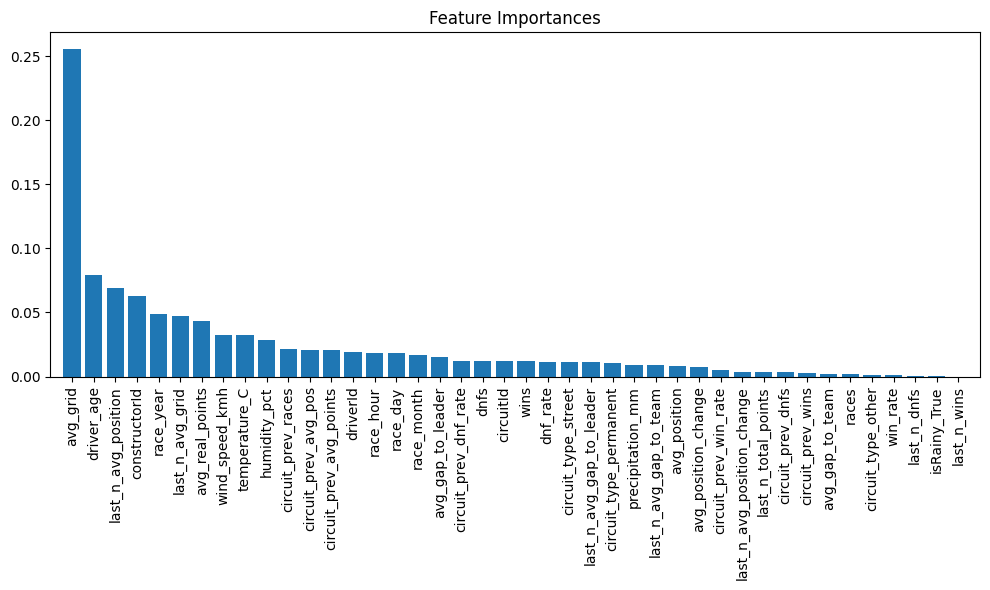

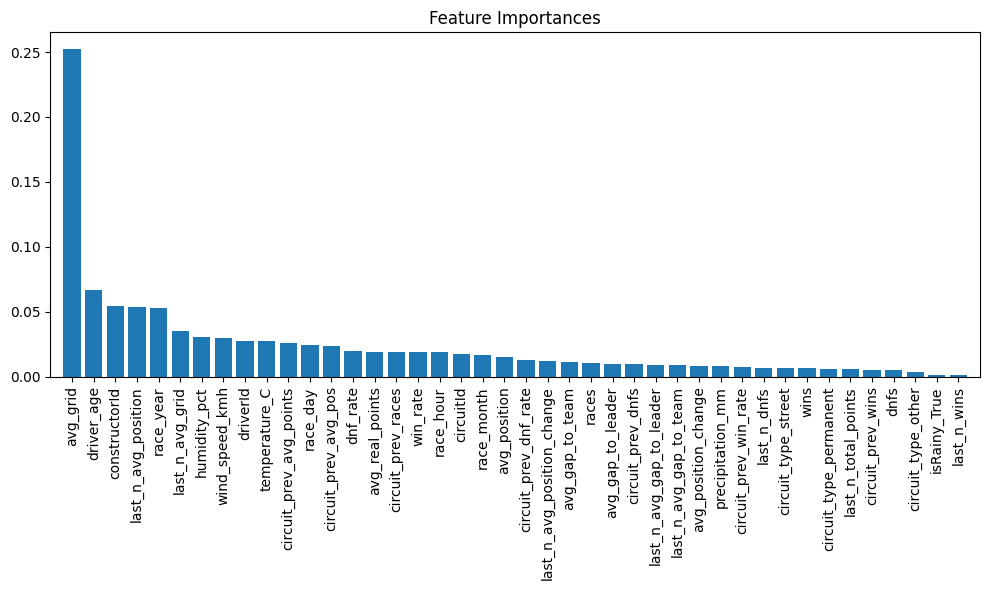

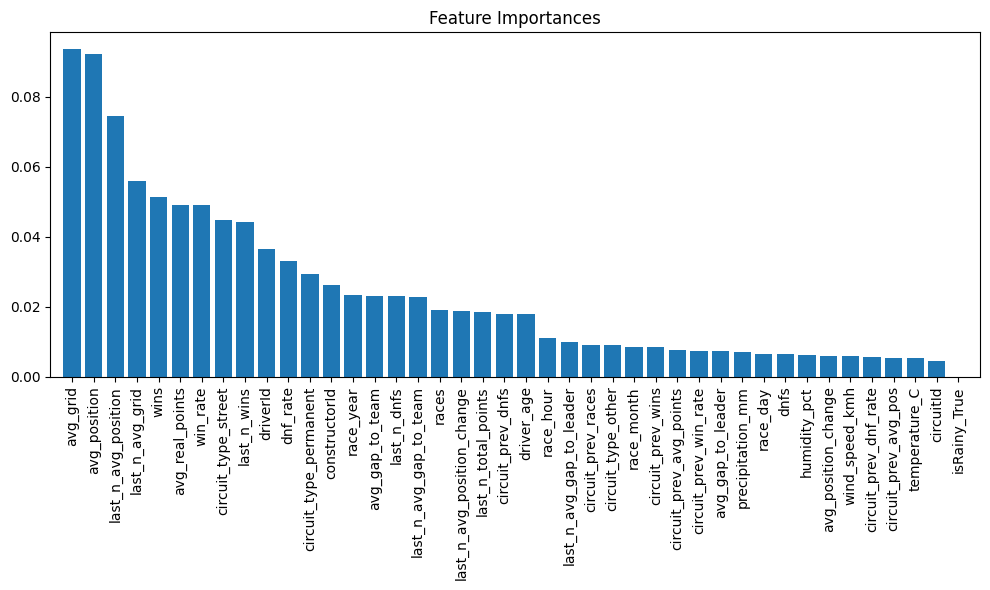

In [9]:
# graficas de los modelos regresores
def plot_feature_importances(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.xlim([-1, len(importances)])
    plt.tight_layout()
    plt.show()
plot_feature_importances(tree, X_train.columns)
plot_feature_importances(forest, X_train.columns)
plot_feature_importances(xgb, X_train.columns)

In [10]:
# Evaluación de modelos
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, r2

# Evaluación de ZeroR
mae_zeroR, mse_zeroR, r2_zeroR = evaluate_model(zeroR, X_test, y_test)
# Evaluación de Decision Tree
mae_tree, mse_tree, r2_tree = evaluate_model(tree, X_test, y_test)
# Evaluación de Random Forest
mae_forest, mse_forest, r2_forest = evaluate_model(forest, X_test, y_test)
# Evaluación de XGBoost
mae_xgb, mse_xgb, r2_xgb = evaluate_model(xgb, X_test, y_test)

# Resultados de evaluación
results = pd.DataFrame({
    'Model': ['ZeroR', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'MAE': [mae_zeroR, mae_tree, mae_forest, mae_xgb],
    'MSE': [mse_zeroR, mse_tree, mse_forest, mse_xgb],
    'R^2': [r2_zeroR, r2_tree, r2_forest, r2_xgb]
})
print("🔍 Evaluation Results:")
print(results)

# el MAE es el error absoluto medio, que mide la media de los errores absolutos entre las predicciones y los valores reales.
# el MSE es el error cuadrático medio, que mide la media de los errores al cuadrado entre las predicciones y los valores reales.
# el R^2 es el coeficiente de determinación, que mide la proporción de la varianza en la variable dependiente que es predecible a partir de las variables independientes.

🔍 Evaluation Results:
           Model       MAE        MSE           R^2
0          ZeroR  5.999148  47.910139 -1.236594e-07
1  Decision Tree  3.345400  26.083049  4.555839e-01
2  Random Forest  2.674804  13.186991  7.247557e-01
3        XGBoost  2.851495  14.934742  6.882759e-01


C:\Users\salva\AppData\Local\Temp\ipykernel_6284\2242096042.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAE', data=results, palette='viridis')


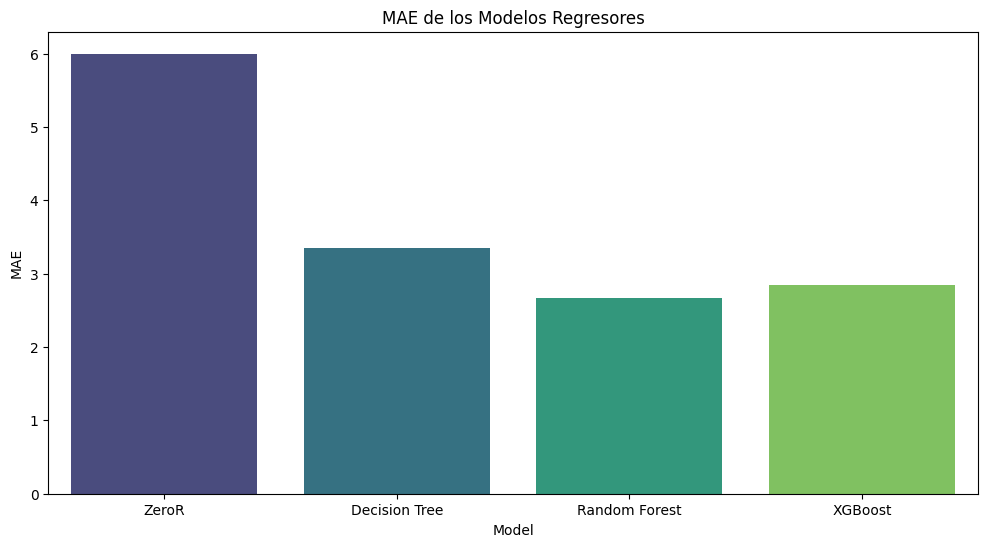

C:\Users\salva\AppData\Local\Temp\ipykernel_6284\2242096042.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MSE', data=results, palette='viridis')


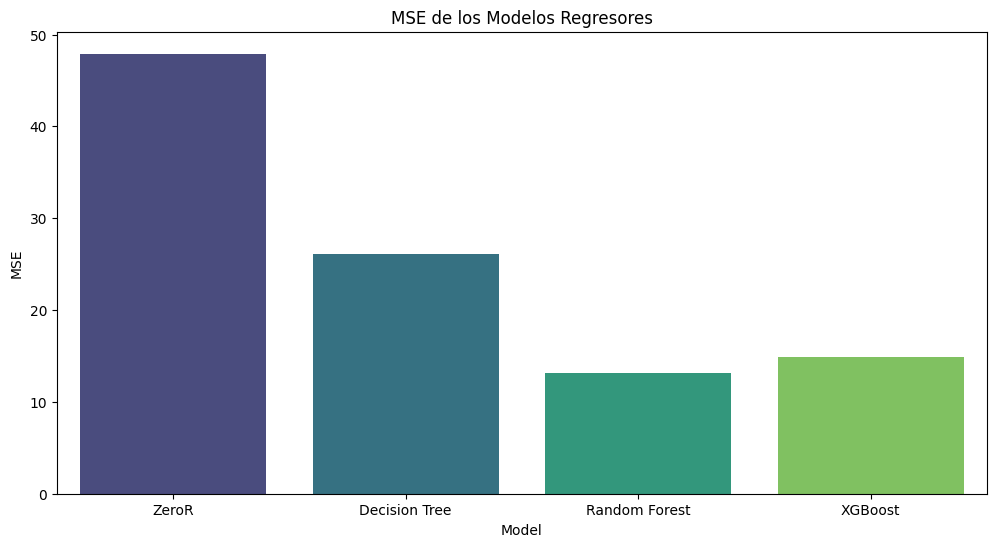

C:\Users\salva\AppData\Local\Temp\ipykernel_6284\2242096042.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R^2', data=results, palette='viridis')


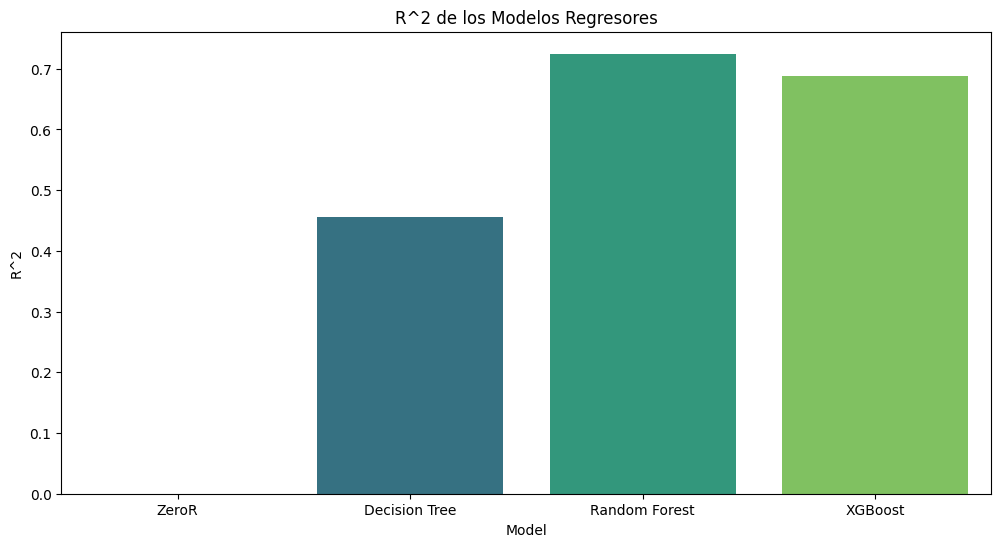

In [11]:
# graficas de los modelos regresores usando results
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='MAE', data=results, palette='viridis')
plt.title('MAE de los Modelos Regresores')
plt.show()
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='MSE', data=results, palette='viridis')
plt.title('MSE de los Modelos Regresores')
plt.show()
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='R^2', data=results, palette='viridis')
plt.title('R^2 de los Modelos Regresores')
plt.show()

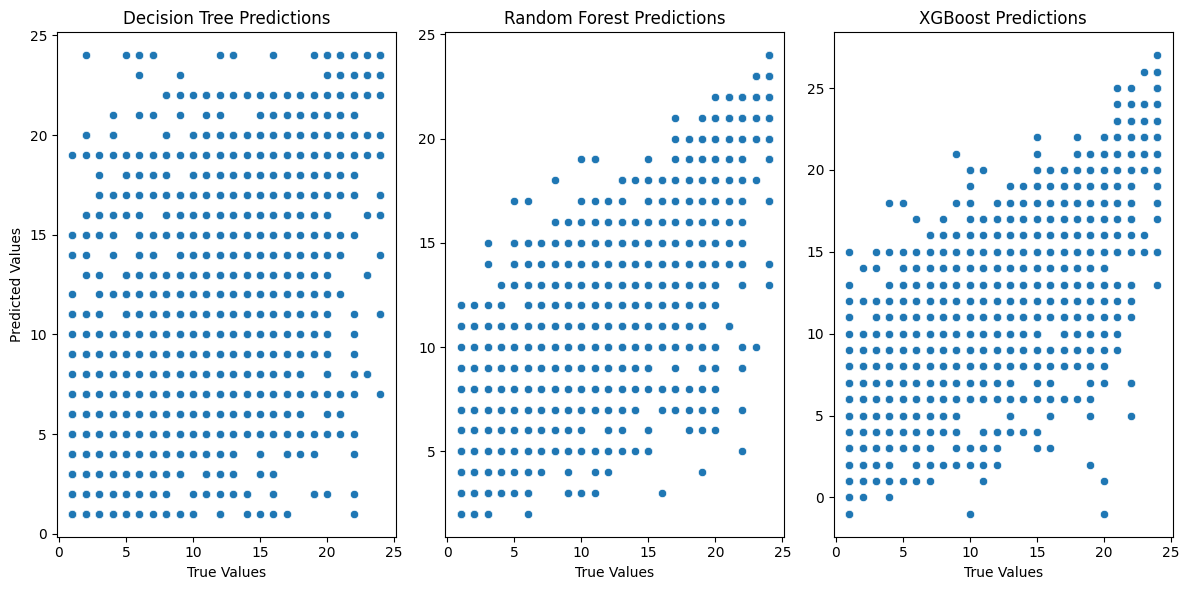

In [12]:
#graficas de comparacion de los modelos
def plot_model_comparison(y_true, y_pred_tree, y_pred_forest, y_pred_xgb):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    sns.scatterplot(x=y_true, y=y_pred_tree)
    plt.title("Decision Tree Predictions")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    
    plt.subplot(1, 3, 2)
    sns.scatterplot(x=y_true, y=y_pred_forest)
    plt.title("Random Forest Predictions")
    plt.xlabel("True Values")
    
    plt.subplot(1, 3, 3)
    sns.scatterplot(x=y_true, y=y_pred_xgb)
    plt.title("XGBoost Predictions")
    plt.xlabel("True Values")

    plt.tight_layout()
    plt.show()
plot_model_comparison(y_test, y_pred_tree_rounded, y_pred_rounded, y_pred_xgb_rounded)




In [13]:
def predecir_grid(modelo, df_original, filtro, features):
    # Filtramos las filas específicas
    df_filtrado = df_original.query(filtro).copy()

    if df_filtrado.empty:
        print("⚠️ No se encontraron filas con ese filtro.")
        return

    X_filtrado = df_filtrado[features]

    # Aplicar el mismo one-hot encoding que en el entrenamiento
    X_filtrado_encoded = pd.get_dummies(X_filtrado, drop_first=True)

    # Alinear columnas con las usadas en el entrenamiento
    X_filtrado_encoded = X_filtrado_encoded.reindex(columns=X.columns, fill_value=0)

    predicciones = modelo.predict(X_filtrado_encoded)
    probabilidades = modelo.predict_proba(X_filtrado_encoded)[:, 1] if hasattr(modelo, "predict_proba") else None

    # Mostramos resultados
    df_filtrado_resultado = df_filtrado.copy()
    df_filtrado_resultado['prediccion_grid'] = predicciones

    return df_filtrado_resultado

In [14]:
#graficar diferencia entre grid y prediccion
def graficar_diferencia_grid(df):
    plt.figure(figsize=(10, 6))
    plt.scatter(df['grid'], df['prediccion_grid'], alpha=0.5)
    plt.plot([df['grid'].min(), df['grid'].max()], [df['grid'].min(), df['grid'].max()], color='red', linestyle='--')
    plt.title('Diferencia entre Grid y Predicción')
    plt.xlabel('Grid Real')
    plt.ylabel('Predicción de Grid')
    plt.grid()
    plt.show()

🔎 Predicciones de grid para: Decision Tree


,raceId,year,circuitRef,driverRef,constructorRef,grid,prediccion_grid
1733,84,2005,istanbul,raikkonen,mclaren,1,24.0
1736,84,2005,istanbul,fisichella,renault,2,2.0
1734,84,2005,istanbul,alonso,renault,3,3.0
1735,84,2005,istanbul,montoya,mclaren,4,3.0
1738,84,2005,istanbul,trulli,toyota,5,5.0
1750,84,2005,istanbul,heidfeld,williams,6,3.0
1752,84,2005,istanbul,webber,williams,7,7.0
1751,84,2005,istanbul,massa,sauber,8,8.0
1744,84,2005,istanbul,ralf_schumacher,toyota,9,15.0
1740,84,2005,istanbul,klien,red_bull,10,18.0


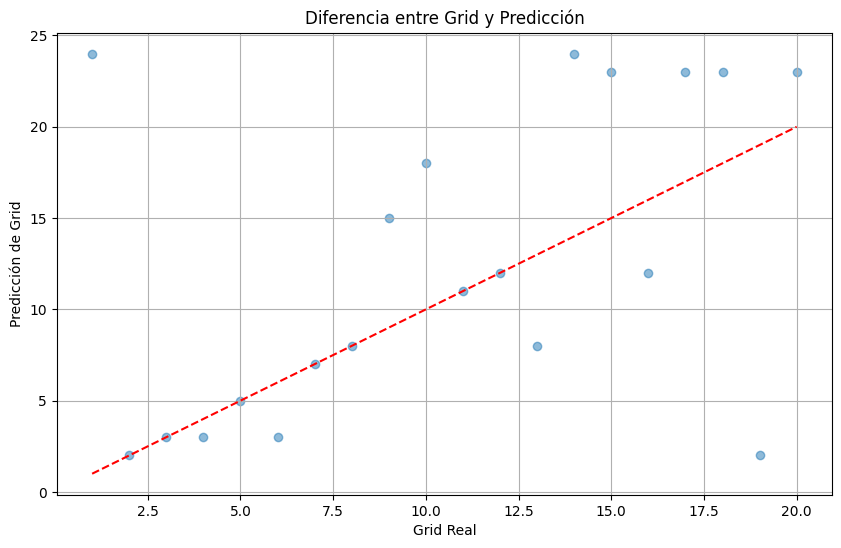

🔎 Predicciones de grid para: Random Forest


,raceId,year,circuitRef,driverRef,constructorRef,grid,prediccion_grid
1733,84,2005,istanbul,raikkonen,mclaren,1,13.72
1736,84,2005,istanbul,fisichella,renault,2,3.39
1734,84,2005,istanbul,alonso,renault,3,3.23
1735,84,2005,istanbul,montoya,mclaren,4,8.86
1738,84,2005,istanbul,trulli,toyota,5,6.78
1750,84,2005,istanbul,heidfeld,williams,6,9.62
1752,84,2005,istanbul,webber,williams,7,7.51
1751,84,2005,istanbul,massa,sauber,8,8.30
1744,84,2005,istanbul,ralf_schumacher,toyota,9,9.96
1740,84,2005,istanbul,klien,red_bull,10,17.85


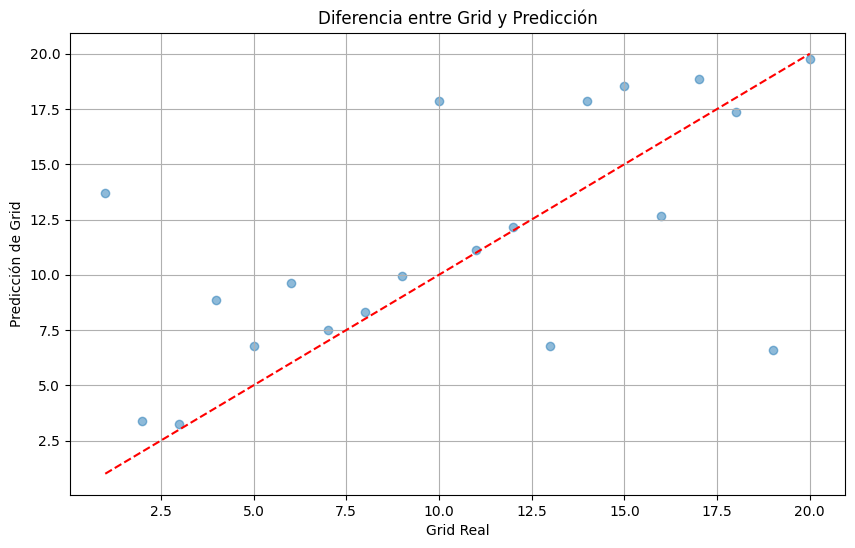

🔎 Predicciones de grid para: XGBoost


,raceId,year,circuitRef,driverRef,constructorRef,grid,prediccion_grid
1733,84,2005,istanbul,raikkonen,mclaren,1,11.181104
1736,84,2005,istanbul,fisichella,renault,2,3.870243
1734,84,2005,istanbul,alonso,renault,3,3.257430
1735,84,2005,istanbul,montoya,mclaren,4,8.536204
1738,84,2005,istanbul,trulli,toyota,5,6.730686
1750,84,2005,istanbul,heidfeld,williams,6,7.260929
1752,84,2005,istanbul,webber,williams,7,6.837684
1751,84,2005,istanbul,massa,sauber,8,7.690297
1744,84,2005,istanbul,ralf_schumacher,toyota,9,11.339995
1740,84,2005,istanbul,klien,red_bull,10,14.219484


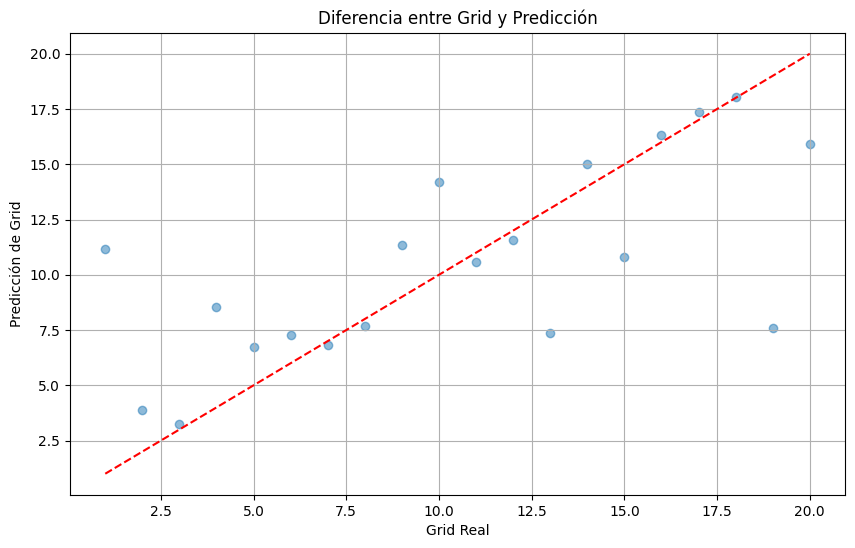

In [15]:
filtro = "raceId == 84"

# Para el árbol de decisión
df_decision_tree = predecir_grid(tree, df_original, filtro, features)
print(f"🔎 Predicciones de grid para: Decision Tree")
display(df_decision_tree.sort_values('grid')[['raceId','year','circuitRef', 'driverRef', 'constructorRef', 'grid', 'prediccion_grid']])
graficar_diferencia_grid(df_decision_tree)

# Para probar con el modelo de Random Forest
df_random_forest = predecir_grid(forest, df_original, filtro, features)
print(f"🔎 Predicciones de grid para: Random Forest")
display(df_random_forest.sort_values('grid')[['raceId','year','circuitRef', 'driverRef', 'constructorRef', 'grid', 'prediccion_grid']])
graficar_diferencia_grid(df_random_forest)

# Para XGBoost
df_xgboost = predecir_grid(xgb, df_original, filtro, features)
print(f"🔎 Predicciones de grid para: XGBoost")
display(df_xgboost.sort_values('grid')[['raceId','year','circuitRef', 'driverRef', 'constructorRef', 'grid', 'prediccion_grid']])
graficar_diferencia_grid(df_xgboost)